In [1]:
import pickle
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
style.use('fivethirtyeight')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\craut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stop_words = set(stopwords.words("english"))

In [3]:
#from lda_modify_inference import modify_lda_inference
#modify_lda_inference()
#from gensim.models.ldamodel import LdaModel
"""
This tutorial is god:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
"""
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from pathlib import Path
home = str(Path.home())
mallet_path = 'C:\\Users\\craut\\Documents\\Documents\\UCI\\2018-2019\\Spring\\DS_Capstone\\Music_Econ\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet' # update this path
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [103]:
df = pickle.load(open("df_concat.pickle","rb"))
print(df.shape)
df.head()

(22708, 16)


,song,artist,genius_raw,genius_bag,az_lyrics_raw,az_lyrics_bag,lyrics_az_raw,lyrics_az_bag,GvAZL,GvLAZ,AZLvLAZ,genius_counter,az_lyrics_counter,lyrics_az_counter,word_intersect,word_intersect_counter
0,sauce it up,lil uzi vert,"[Intro]\nSauce it up, ayy, sauce it up, ayy\nS...","[sauce, it, up, ayy, sauce, it, up, ayy, sauce...","Sauce it up, ayy, sauce it up, ayy<br>\nSauce ...","[sauce, it, up, ayy, sauce, it, up, ayy, sauce...",[Intro]<br />\nSauce it up (aye)<br />\nSauce ...,"[sauce, it, up, aye, sauce, it, up, aye, sauce...",0.981573,0.852666,0.864487,"{'sauce': 18, 'it': 32, 'up': 36, 'ayy': 7, 'g...","{'sauce': 18, 'it': 32, 'up': 36, 'ayy': 7, 'i...","{'sauce': 12, 'it': 28, 'up': 24, 'aye': 6, 'g...","[let, okay, say, on, harley, brrr, woo, cardi,...","{'let': 2.0, 'okay': 1.0, 'say': 2.0, 'on': 4...."
1,backroad song,granger smith,Barbed wire fence carving out a hillside\nCutt...,"[barb, wire, fence, carve, out, a, hillside, c...","Barbed wire fence carving out a hillside, cutt...","[barb, wire, fence, carve, out, a, hillside, c...","Barbed wire fence carving out a hillside, cutt...","[barb, wire, fence, carve, out, a, hillside, c...",0.996372,0.997579,0.998789,"{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...","{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...","{'barb': 1, 'wire': 1, 'fence': 1, 'carve': 1,...","[let, feel, we're, today, grey, on, song, hear...","{'let': 1.0, 'feel': 11.0, 'we're': 1.0, 'toda..."
2,feelin' satisfied,boston,[Verse 1]\nWell come on\nAll you people\nThe t...,"[well, come, on, all, you, people, the, time, ...",Well come on<br>\nAll you people<br>\nThe time...,"[well, come, on, all, you, people, the, time, ...",Well come on<br />\nAll you people<br />\nThe ...,"[well, come, on, all, you, people, the, time, ...",0.949709,0.946203,0.996477,"{'well': 2, 'come': 9, 'on': 9, 'all': 1, 'you...","{'well': 2, 'come': 10, 'on': 11, 'all': 1, 'y...","{'well': 2, 'come': 10, 'on': 11, 'all': 1, 'y...","[people, let, can, alright, satisfy, feel, giv...","{'people': 1.0, 'let': 8.0, 'can': 2.0, 'alrig..."
3,saturday morning confusion,bobby russell,"Here they come, warming up\nI hear the pitter ...","[here, they, come, warm, up, i, hear, the, pit...",None,None,"Here they come, warming up<br />\nI hear the p...","[here, they, come, warm, up, i, hear, the, pit...",0.000000,0.999033,0.000000,"{'here': 3, 'they': 3, 'come': 3, 'warm': 2, '...",{},"{'here': 3, 'they': 3, 'come': 3, 'warm': 2, '...","[let, feel, dog, today, how, hear, on, come, r...","{'let': 2.0, 'feel': 1.0, 'dog': 4.0, 'today':..."
4,country man,luke bryan,"[Verse 1]\nYou need hands, rough not soft\nTo ...","[you, need, hand, rough, not, soft, to, come, ...","You need hands, rough not soft<br>\nTo come an...","[you, need, hand, rough, not, soft, to, come, ...","You need hands, rough not soft<br />\nTo come ...","[you, need, hand, rough, not, soft, to, come, ...",0.971121,0.967205,0.991220,"{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...","{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...","{'you': 7, 'need': 1, 'hand': 2, 'rough': 1, '...","[let, gator, tenni, move, come, way, muscle, t...","{'let': 1.0, 'gator': 1.0, 'tenni': 1.0, 'move..."


In [104]:
#df = df.iloc[:20,:]
#df

In [59]:
word = pickle.load(open("bag_of_words_concat.pickle","rb"))
print(word.shape)
word.head()

(39300, 3)


,word,songcount,wordcount
0,truthfulne,1,1
1,ornate,1,1
2,quieren,2,3
3,decadence,3,3
4,robe,12,19


In [62]:
words = set()
for i,r in word.iterrows():
    w,sc,wc = r 
    if sc >= 10:
        words.add(w)
words = words-stop_words
print(len(words))

6686


In [68]:
# #strict union bag of words model 
# data_sources = ["genius","az_lyrics","lyrics_az"]
# min_cnt_data = []
# for i,r in df.iterrows():
#     bags = []
#     for ds in data_sources:
#         if r["{}_raw".format(ds)]:
#             bags.append(r["{}_counter".format(ds)])
#     final_bag = {}
#     if len(bags) == 1:
#         final_bag = bags[0]
#     elif len(bags) >1:
#         final_bag = {w:min(bags[0][w],bags[1][w]) for w in bags[0] if w in bags[1]}
#         if len(bags) == 3:
#             final_bag = {w:min(final_bag[w],bags[2][w]) for w in final_bag if w in bags[2]}
#     else:
#         print("big problem, no bags for ({},{})".format(r["song"],r["artist"]))
#         print(bags)
#     words_list = [w for w in final_bag for i in range(final_bag[w]) if w in words]
#     min_cnt_data.append([r["song"],r["artist"],words_list])
# agg_df = pd.DataFrame(min_cnt_data,columns=["song","artist","list"])
# print(agg_df.shape)
# agg_df

(20, 3)


,song,artist,list
0,sauce it up,lil uzi vert,"[sauce, sauce, sauce, sauce, sauce, sauce, sau..."
1,backroad song,granger smith,"[barb, wire, fence, carve, hillside, cut, cut,..."
2,feelin' satisfied,boston,"[well, well, come, come, come, come, come, com..."
3,saturday morning confusion,bobby russell,"[come, come, come, warm, warm, hear, hear, hea..."
4,country man,luke bryan,"[hand, hand, rough, soft, come, come, warm, co..."
5,try,p!nk,"[ever, ever, wonder, turn, lie, sometime, thin..."
6,big in japan,alphaville,"[winter, side, crystal, bit, snowflake, around..."
7,cheeseburger in paradise,jimmy buffett,"[try, amend, habit, make, nearly, day, day, lo..."
8,landslide,olivia newton-john,"[cold, wind, rarely, blow, end, rainbow, guess..."
9,some enchanted evening,jane olivor,"[enchant, enchant, enchant, even, even, even, ..."


In [80]:
# #flooring averaged bag of words cnts
# data_sources = ["genius","az_lyrics","lyrics_az"]
# min_cnt_data = []
# for i,r in df.iterrows():
#     final_bag = r["word_intersect_counter"]
#     words_list = [w for w in final_bag for i in range(int(final_bag[w])) if w in words]
#     min_cnt_data.append([r["song"],r["artist"],words_list])
# agg_df2 = pd.DataFrame(min_cnt_data,columns=["song","artist","list"])
# print(agg_df2.shape)
# agg_df2

(20, 3)


,song,artist,list
0,sauce it up,lil uzi vert,"[let, let, okay, say, say, harley, brrr, woo, ..."
1,backroad song,granger smith,"[let, feel, feel, feel, feel, feel, feel, feel..."
2,feelin' satisfied,boston,"[people, let, let, let, let, let, let, let, le..."
3,saturday morning confusion,bobby russell,"[let, let, feel, dog, dog, dog, dog, today, he..."
4,country man,luke bryan,"[let, gator, tenni, move, come, come, way, mus..."
5,try,p!nk,"[fall, right, even, mean, mean, mean, cry, die..."
6,big in japan,alphaville,"[neon, big, big, big, big, big, big, big, big,..."
7,cheeseburger in paradise,jimmy buffett,"[say, hear, dream, way, worth, big, big, draft..."
8,landslide,olivia newton-john,"[fall, feel, feel, say, say, say, say, say, fa..."
9,some enchanted evening,jane olivor,"[stranger, stranger, let, let, even, even, eve..."


In [105]:
#each data source is new entry
data_sources = ["genius","az_lyrics","lyrics_az"]
min_cnt_data = []
for i,r in df.iterrows():
    for ds in data_sources:
        if r["{}_bag".format(ds)]:
            words_list = [w for w in r["{}_bag".format(ds)] if w in words]
            min_cnt_data.append([r["song"],r["artist"],words_list])
agg_df3 = pd.DataFrame(min_cnt_data,columns=["song","artist","list"])
print(agg_df3.shape)
agg_df3

(55295, 3)


,song,artist,list
0,sauce it up,lil uzi vert,"[sauce, ayy, sauce, ayy, sauce, ayy, go, numb,..."
1,sauce it up,lil uzi vert,"[sauce, ayy, sauce, ayy, sauce, ayy, love, i'm..."
2,sauce it up,lil uzi vert,"[sauce, aye, sauce, aye, sauce, aye, go, dumb,..."
3,backroad song,granger smith,"[barb, wire, fence, carve, hillside, cut, hole..."
4,backroad song,granger smith,"[barb, wire, fence, carve, hillside, cut, hole..."
5,backroad song,granger smith,"[barb, wire, fence, carve, hillside, cut, hole..."
6,feelin' satisfied,boston,"[well, come, people, time, come, get, together..."
7,feelin' satisfied,boston,"[well, come, people, time, come, get, together..."
8,feelin' satisfied,boston,"[well, come, people, time, come, get, together..."
9,saturday morning confusion,bobby russell,"[come, warm, hear, little, people, live, room,..."


In [18]:
# #only looking at genius
# gen_df = df[~df["genius_raw"].isna()][["song","artist","genius_bag"]]
# print(gen_df.shape)
# gen_df.head()

(19, 3)


,song,artist,genius_bag
0,sauce it up,lil uzi vert,"[sauce, it, up, ayy, sauce, it, up, ayy, sauce..."
1,backroad song,granger smith,"[barb, wire, fence, carve, out, a, hillside, c..."
2,feelin' satisfied,boston,"[well, come, on, all, you, people, the, time, ..."
3,saturday morning confusion,bobby russell,"[here, they, come, warm, up, i, hear, the, pit..."
4,country man,luke bryan,"[you, need, hand, rough, not, soft, to, come, ..."


In [6]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [106]:
#texts = remove_stopwords(list(gen_df["genius_bag"]))
texts = list(agg_df3["list"])

In [107]:
id2word = corpora.Dictionary(texts)

In [108]:
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 24), (3, 1), (4, 2), (5, 2), (6, 2), (7, 7), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 11), (26, 1), (27, 24), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 4), (39, 21), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 10), (49, 1), (50, 1), (51, 11), (52, 1), (53, 2), (54, 1), (55, 2), (56, 1), (57, 2), (58, 1), (59, 2), (60, 6), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 13), (69, 1), (70, 3), (71, 1), (72, 1), (73, 9), (74, 2), (75, 1), (76, 3), (77, 6), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 18), (85, 2), (86, 1), (87, 2), (88, 8), (89, 1), (90, 1), (91, 3), (92, 1), (93, 2), (94, 1), (95, 2), (96, 1), (97, 2), (98, 16), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 1), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1),

In [109]:
#lda_lyr = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [110]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.231*"go" + 0.174*"come" + 0.146*"let" + 0.041*"around" + 0.039*"we\'re" + '
  '0.031*"rock" + 0.027*"everybody" + 0.021*"roll" + 0.021*"yo" + '
  '0.018*"wild"'),
 (1,
  '0.119*"nigga" + 0.091*"fuck" + 0.085*"ya" + 0.082*"shit" + 0.065*"bitch" + '
  '0.060*"money" + 0.059*"na" + 0.036*"gon" + 0.032*"ain\'t" + 0.024*"hoe"'),
 (2,
  '0.077*"time" + 0.068*"one" + 0.037*"man" + 0.034*"try" + 0.029*"keep" + '
  '0.023*"well" + 0.022*"still" + 0.022*"home" + 0.018*"friend" + 0.017*"cry"'),
 (3,
  '0.104*"never" + 0.059*"i\'ve" + 0.057*"life" + 0.050*"find" + 0.044*"every" '
  '+ 0.042*"live" + 0.038*"ever" + 0.035*"much" + 0.035*"alway" + '
  '0.031*"lose"'),
 (4,
  '0.185*"world" + 0.084*"song" + 0.083*"sing" + 0.076*"blue" + 0.072*"old" + '
  '0.068*"soul" + 0.057*"rain" + 0.036*"rise" + 0.034*"write" + 0.033*"whole"'),
 (5,
  '0.212*"make" + 0.185*"want" + 0.177*"feel" + 0.134*"right" + 0.108*"good" + '
  '0.066*"thing" + 0.029*"bad" + 0.029*"ah" + 0.016*"kind" + 0.010*"inside"'

In [112]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35866836465763874


In [39]:
def pickle_dump_model(model,fname):
    pickle.dump(model,open(fname,'wb'))
def pickle_load_model(fname):
    return pickle.load(open(fname,'rb'))

In [113]:
clust_2_coherence = {}
def lda_modeling(min_clusters,max_clusters):
    for n_clusters in range(min_clusters,max_clusters+1):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n_clusters, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
        pickle_dump_model(lda_model,"../data/lda_pickles/lda_model_{}_songs_{}_clusters.pickle".format(len(corpus),n_clusters))
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        clust_2_coherence[n_clusters]=coherence_lda
        print("done with {}-many topics".format(n_clusters))
    print("{} many words. {} many songs".format(len(id2word),len(corpus)))
    return clust_2_coherence

In [114]:
results = lda_modeling(5,50)

done with 5-many topics
done with 6-many topics
done with 7-many topics
done with 8-many topics
done with 9-many topics
done with 10-many topics
done with 11-many topics
done with 12-many topics
done with 13-many topics
done with 14-many topics
done with 15-many topics
done with 16-many topics
done with 17-many topics
done with 18-many topics
done with 19-many topics
done with 20-many topics
done with 21-many topics
done with 22-many topics
done with 23-many topics
done with 24-many topics
done with 25-many topics
done with 26-many topics
done with 27-many topics
done with 28-many topics
done with 29-many topics
done with 30-many topics
done with 31-many topics
done with 32-many topics
done with 33-many topics
done with 34-many topics
done with 35-many topics


KeyboardInterrupt: 

In [115]:
sns.lineplot(x=[t for t,c,m in results],y=[c for t,c,m in results])

TypeError: 'int' object is not iterable

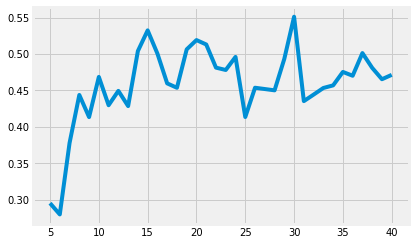

In [79]:
sns.lineplot(x=[c for c in results],y=[results[c] for c in results])

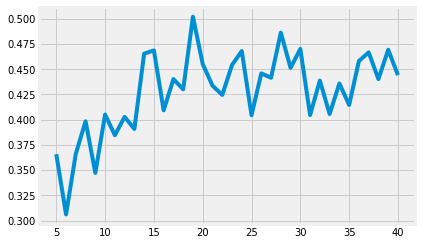

In [88]:
sns.lineplot(x=[c for c in results],y=[results[c] for c in results])

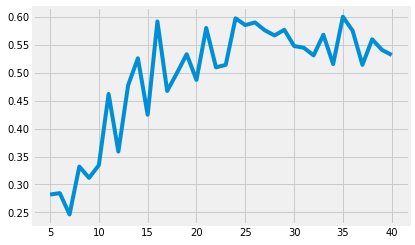

In [116]:
sns.lineplot(x=[c for c in results],y=[results[c] for c in results])

In [117]:
ntopics = 24
print("Correlation  = {} ({} topics)".format(results[ntopics],ntopics))
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(pickle.load(open("../data/lda_pickles/lda_model_55295_songs_{}_clusters.pickle".format(ntopics),"rb")), corpus, id2word)
vis

Correlation  = 0.5974601727704846 (24 topics)


c:\users\craut\miniconda3\envs\music_econ\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22    -0.150700 -0.261799       1        1  13.771458
17    -0.094056 -0.217190       2        1   7.892925
3     -0.076917 -0.091373       3        1   7.634740
2     -0.078061 -0.072380       4        1   6.192059
12     0.048676 -0.156415       5        1   5.987010
8      0.060755 -0.048720       6        1   5.557868
10    -0.047408 -0.132250       7        1   5.016766
9     -0.220522  0.221629       8        1   4.909118
0     -0.026679  0.011083       9        1   4.587611
16     0.081827 -0.024597      10        1   4.083340
1     -0.323111  0.138745      11        1   3.984004
15     0.101914  0.028980      12        1   3.482793
20     0.027523  0.065425      13        1   3.412288
6      0.060855  0.030785      14        1   2.996034
7     -0.131544  0.093049      15        1   2.880373
23     0.065769 -0.056676      16        1   2.870592
5      0.052757  0.107828      17        1   2.423773
4      0.111447  0.047592      18        1   1.972118
14     0.083050  0.030310      19        1   1.921176
18     0.111812  0.046701      20        1   1.835575
19     0.039451  0.091285      21        1   1.828318
13     0.104674  0.051906      22        1   1.791438
21     0.090904  0.060306      23        1   1.744660
11     0.107584  0.035776      24        1   1.223961, topic_info=     Category           Freq       Term          Total  loglift  logprob
62    Default  197468.000000       love  197468.000000  30.0000  30.0000
37    Default  233748.000000        get  233748.000000  29.0000  29.0000
51    Default  210564.000000        i'm  210564.000000  28.0000  28.0000
60    Default  144787.000000       like  144787.000000  27.0000  27.0000
55    Default  159806.000000       know  159806.000000  26.0000  26.0000
110   Default  103713.000000       yeah  103713.000000  25.0000  25.0000
74    Default  109191.000000         oh  109191.000000  24.0000  24.0000
8     Default  105562.000000       baby  105562.000000  23.0000  23.0000
85    Default   98843.000000        say   98843.000000  22.0000  22.0000
125   Default   98057.000000       come   98057.000000  21.0000  21.0000
39    Default  133516.000000         go  133516.000000  20.0000  20.0000
537   Default   74691.000000       want   74691.000000  19.0000  19.0000
170   Default   58217.000000        way   58217.000000  18.0000  18.0000
186   Default   51734.000000       i'll   51734.000000  17.0000  17.0000
113   Default   51028.000000      wanna   51028.000000  16.0000  16.0000
184   Default   50933.000000      gonna   50933.000000  15.0000  15.0000
38    Default   64791.000000       girl   64791.000000  14.0000  14.0000
349   Default   78535.000000        see   78535.000000  13.0000  13.0000
191   Default   69589.000000      never   69589.000000  12.0000  12.0000
63    Default   89725.000000       make   89725.000000  11.0000  11.0000
59    Default   83549.000000        let   83549.000000  10.0000  10.0000
99    Default   82964.000000       time   82964.000000   9.0000   9.0000
203   Default   57408.000000       tell   57408.000000   8.0000   8.0000
48    Default   39718.000000        hey   39718.000000   7.0000   7.0000
202   Default   67126.000000       take   67126.000000   6.0000   6.0000
97    Default   56284.000000      think   56284.000000   5.0000   5.0000
64    Default   47318.000000        man   47318.000000   4.0000   4.0000
321   Default   43471.000000       good   43471.000000   3.0000   3.0000
216   Default   58358.000000       back   58358.000000   2.0000   2.0000
519   Default   37651.000000       life   37651.000000   1.0000   1.0000
...       ...            ...        ...            ...      ...      ...
4840  Topic24       0.052028    village       1.264771   1.2122 -14.4336
1364  Topic24       0.052028     jungle       1.264771   1.2122 -14.4336
1331  Topic24       0.052028      chain       1.264774   1.2122 -14.433

In [111]:
pickle_dump_model(lda_model,"../data/lda_pickles/test_lda_model")

In [47]:
test_model = pickle_load_model("../data/lda_pickles/test_lda_model")

In [48]:
coherence_model_lda = CoherenceModel(model=test_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47211163062625433


In [57]:
len(corpus)

19

In [119]:
pickle.dump(texts,open("texts.pickle","wb"))
pickle.dump(corpus,open("corpus.pickle","wb"))
pickle.dump(id2word,open("id2word.pickle","wb"))
pickle.dump(results,open("coherence_scores.pickle","wb"))
pickle.dump(vis,open("vis_24_topics.pickle","wb"))